In [1]:
import os

In [2]:
len(os.listdir('data/cocoa/BlackPod/'))

869

# CocoaNet - CNN to Identify Cocoa Infections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
import torch, torchvision
from torch import optim
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda', index=0)

# Get the data

In [4]:
path = 'data/cocoa/'

**image transformations for training and test sets**

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

**create dataset for training set**

In [6]:
train_dataset = datasets.ImageFolder(path+'train', transform=train_transforms)
val_dataset = datasets.ImageFolder(path+'valid', transform=test_transforms)

**number of images in training and validation set**

In [7]:
print(f'Training set: {len(train_dataset)}\tValidation set: {len(val_dataset)}')

Training set: 136	Validation set: 34


In [8]:
class_names = train_dataset.classes
class_names

['black pod', 'healthy']

**create dataloaders for training and validation sets**

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, 32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, 16, shuffle=True)

## Visualize the data

In [10]:
def imshow(image, title=None):
    # convert to numpy array and rearrange the order of the channels
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # unnormalize the image
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # plot the image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [11]:
images, labels = iter(val_loader).next()
grid = torchvision.utils.make_grid(images)

labels = [class_names[label] for label in labels]

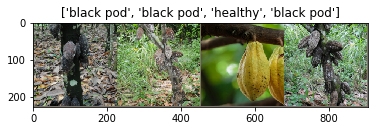

In [12]:
imshow(grid, title=labels)

# Define train function

In [12]:
def train(model, optimizer, criterion, epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    training_losses = []
    validation_losses = []
    for e in range(epochs):
        # training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # forward pass
            optimizer.zero_grad()
            logits = model(images)
            # calculate loss and backpropagate the error
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            # validation phase
            accuracy = 0.0
            val_loss = 0.0
            with torch.no_grad():
                model.eval() 
                
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    # forward pass
                    logits = model(images)
                    loss = criterion(logits, labels)
                    # calculate accuracy
                    probs = torch.exp(logits)
                    top_p, top_c = probs.topk(1, dim=1)
                    equals = top_c == labels.view(*top_c.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
                    val_loss += loss
            accuracy = accuracy / len(val_loader)

            # print statistics
            print('Epoch: {}/{}...'.format(e+1, epochs),
                  'Training loss: {:.3f}...'.format(running_loss / len(train_loader)),
                  'Validation loss: {:.3f}...'.format(val_loss / len(val_loader)),
                  'Validation acc: {:.3f}...'.format(accuracy))
            
            training_losses.append(running_loss / len(train_loader))
            validation_losses.append(val_loss / len(val_loader))
            
            # find the best accuracy so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model_weights)
    return model, (training_losses, validation_losses)

## Create model

In [13]:
model = models.resnet18(pretrained=True)

**freeze the parameters of the model**

In [14]:
for param in model.parameters():
    param.requires_grad = False

**replace the fully connected layer**

In [15]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [16]:
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1))

In [17]:
model = model.to(device)

## Create optimizer and criterion

In [18]:
optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss()

## Train the model

In [19]:
nb_epochs = 10

In [20]:
model, losses = train(model, optimizer, criterion, nb_epochs)

Epoch: 1/10... Training loss: 0.773... Validation loss: 0.672... Validation acc: 0.583...
Epoch: 2/10... Training loss: 0.591... Validation loss: 0.537... Validation acc: 0.938...
Epoch: 3/10... Training loss: 0.714... Validation loss: 0.378... Validation acc: 0.771...
Epoch: 4/10... Training loss: 0.536... Validation loss: 0.376... Validation acc: 0.958...
Epoch: 5/10... Training loss: 0.520... Validation loss: 0.359... Validation acc: 0.979...
Epoch: 6/10... Training loss: 0.443... Validation loss: 0.274... Validation acc: 0.979...
Epoch: 7/10... Training loss: 0.365... Validation loss: 0.245... Validation acc: 0.979...
Epoch: 8/10... Training loss: 0.412... Validation loss: 0.208... Validation acc: 0.979...
Epoch: 9/10... Training loss: 0.323... Validation loss: 0.141... Validation acc: 0.979...
Epoch: 10/10... Training loss: 0.359... Validation loss: 0.166... Validation acc: 0.979...


### Plot loss curves

In [ ]:
plt.plot(nb_epochs, losses[0], 'r', label='Training loss')
plt.plot(nb_epochs, losses[1], 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Unfreeze model and train again

In [30]:
for param in model.parameters():
    param.requires_grad = True

In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
nb_epochs = 10

model, losses = train(model, optimizer, criterion, nb_epochs)

Epoch: 1/10... Training loss: 0.382... Validation loss: 3.151... Validation acc: 0.771...
Epoch: 2/10... Training loss: 0.378... Validation loss: 0.061... Validation acc: 0.979...
Epoch: 3/10... Training loss: 0.331... Validation loss: 0.033... Validation acc: 1.000...
Epoch: 4/10... Training loss: 0.255... Validation loss: 0.093... Validation acc: 0.979...
Epoch: 5/10... Training loss: 0.279... Validation loss: 0.369... Validation acc: 0.958...
Epoch: 6/10... Training loss: 0.236... Validation loss: 0.003... Validation acc: 1.000...
Epoch: 7/10... Training loss: 0.339... Validation loss: 2.289... Validation acc: 0.896...
Epoch: 8/10... Training loss: 0.264... Validation loss: 0.632... Validation acc: 0.917...
Epoch: 9/10... Training loss: 0.235... Validation loss: 0.260... Validation acc: 0.979...
Epoch: 10/10... Training loss: 0.206... Validation loss: 0.113... Validation acc: 1.000...


### Plot loss curves

In [ ]:
plt.plot(nb_epochs, losses[0], 'r', label='Training loss')
plt.plot(nb_epochs, losses[1], 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()